In [1]:
!pip install chumpy
!pip install open3d

     |████████████████████████████████| 51kB 2.6MB/s eta 0:00:011
  Created wheel for chumpy: filename=chumpy-0.70-cp37-none-any.whl size=58291 sha256=a87270838e8536dda7270f8262866cb8ef6f8226b7ef91ddb7231440cbd40994
  Stored in directory: /root/.cache/pip/wheels/0a/73/91/b8dbef9746a907c8c008fc194a9691224ca3371b55f16f1dbd
Successfully built chumpy
     |████████████████████████████████| 188.4MB 74kB/s 


In [1]:
##Mano

import numpy as np
import scipy
import pickle
import sys
import chumpy
import cv2 as cv

def write_int(file, val):
    file.write(int(val).to_bytes(4, byteorder=sys.byteorder))

def write_arr(file, arr):
    file.write(arr.tobytes())

class Mano:
    def __init__(self, path):
        self.path = path
        self._read()

    def print_data_format(self, data):
        """Useful for understanding stored data format in pkl file"""
        for key, value in data.items():
            print(f"{key}:\t{type(value)}", end=" ")
            if isinstance(value, np.ndarray):
                print(value.shape)
            elif isinstance(value, scipy.sparse.csc.csc_matrix):
                print(value.shape)
            elif isinstance(value, str):
                print(value)
            elif isinstance(value, ch.reordering.Select):
                print(value.shape)

        # output:
        # hands_components:   <class 'numpy.ndarray'> (45, 45) each row is a basis vector i.e. 45 basis vectors in 45 dimension
        # f:                  <class 'numpy.ndarray'> (1538, 3) faces
        # J_regressor:        <class 'scipy.sparse.csc.csc_matrix'> (16, 778)
        # kintree_table:      <class 'numpy.ndarray'> (2, 16) [:,i]=[parent[i],i]
        # J:                  <class 'numpy.ndarray'> (16, 3)
        # bs_style:           <class 'str'> lbs
        # hands_coeffs:       <class 'numpy.ndarray'> (1554, 45) what is this?
        # weights:            <class 'numpy.ndarray'> (778, 16)
        # posedirs:           <class 'numpy.ndarray'> (778, 3, 135) pose blends
        # hands_mean:         <class 'numpy.ndarray'> (45,)
        # v_template:         <class 'numpy.ndarray'> (778, 3)
        # shapedirs:          <class 'chumpy.reordering.Select'> (778, 3, 10) shape blends
        # bs_type:            <class 'str'> lrotmin

    def _read(self):
        """Reads MANO data from pkl file."""
        with open(self.path, "rb") as file:
            data = pickle.load(file, encoding="latin1")

        
        # parameters required (names as per paper)
        self.V_temp = data["v_template"]
        self.J_reg = data["J_regressor"]
        self.S = np.array(data["shapedirs"])
        self.P = data["posedirs"]
        self.W = data["weights"]

        # pose pca parameters
        self.pose_pca_basis = data["hands_components"]
        self.pose_pca_mean = data["hands_mean"]
        self.data_pose_pca_coeffs = data["hands_coeffs"]

        # supporting parameters
        self.triangles = data["f"]
        self.parent = data["kintree_table"][0].astype(np.int32)

        # dependent parameters
        self.n_joints = self.J_reg.shape[0]
        self.n_vertices = self.V_temp.shape[0]
        self.n_triangles = self.triangles.shape[0] 

        # n_comps = 7
        # hands_components = data["hands_components"]
        # hands_mean = data["hands_mean"]
        # hands_coeffs = data["hands_coeffs"]
        # selected_components = hands_components[:n_comps]
        # pose_coeffs = np.zeros(3+n_comps)   # 3: global orientation
        # full_hand_pose = pose_coeffs[3:].dot(selected_components)
        # print(hands_coeffs[1000])

In [42]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import tensorflow as tf
from tensorflow import keras
import os
import datetime
from glob import glob
import time
import scipy
import sys
from mesh_sampling import generate_transform_matrices
## Installation for this is mentioned over -> https://github.com/MPI-IS/mesh
from psbody.mesh import Mesh
import openmesh as om
from sklearn.neighbors import KDTree

In [43]:
# tf.debugging.experimental.enable_dump_debug_info("./logs/tfdbg2_logdir",
#     tensor_debug_mode="FULL_HEALTH",
#     circular_buffer_size=-1)

# Global Constants

In [44]:
EPSILON = 0.0001             ## 
AUGMENT = 1                  ## Add image augmentation (introduce random clipping, rotation and scaling)
PAD = 30                     ## 
SEQ_LENGTH = 8               ##Spiral convolulational neighbourhood length
OUT_IMAGE_SIZE = (224, 224)  ## Paper says 192x192 crops

CROP_OFFSET_RANGE = [-5, 5]  ## 
ROTATION_RANGE = [-180, 180] ## 

## Hyperparameters
lamb_edge = 0.01             ##
lamb_vert = 0.01             ##
learning_rate = 0.1e-4

imagenet_mean=np.array([0.485, 0.456, 0.406])
imagenet_std=np.array([0.229, 0.224, 0.225])

# Data reading 
In this case a single image and its corresponding annotation

In [45]:
with open('../storage/correct_sample.json') as f:
    train_data = json.load(f)

In [46]:
print("Data keys:", [k for k in train_data.keys()])
print("Image keys:", [k for k in train_data['images'][0].keys()])
print("Annotations keys:", [k for k in train_data['annotations'][0].keys()])

print("The number of images:", len(train_data['images']))
print("The number of annotations:", len(train_data['annotations']))

Data keys: ['images', 'annotations']
Image keys: ['id', 'name', 'height', 'width']
Annotations keys: ['vertices', 'is_left', 'image_id', 'id']
The number of images: 1
The number of annotations: 1


In [47]:
def retrieve_sample(data, image_name):
    """
    Retrieve annotations for a particular image
    """
    annotation_list = []
    image = None
    for im in data['images']:
        if im['name'] == image_name:
            image = im
    
    for ann in data['annotations']:
        if ann['image_id'] == image['id']:
            annotation_list.append(ann)

    return annotation_list, image

In [48]:
def visualize_in_orig_image(image_path, width, height, annotations):
    """
    Visualize hand annotations and image on uncropped original image
    """
    image = Image.open(image_path)
    image = image.resize((width, height), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    vertices = np.array(annotations['vertices'])
    plt.plot(vertices[:, 0], vertices[:, 1], 'o', color='green', markersize=1)
    plt.show()

In [49]:
# Get the cropped image at this stage
annotation_list, image  = retrieve_sample(train_data, train_data['images'][0]['name'])

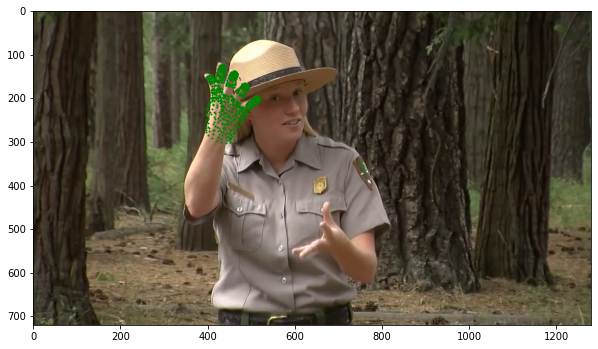

In [50]:
visualize_in_orig_image('../storage/data/'+image['name'], image['width'], image['height'], annotation_list[0])

# Image data and annotations processing

In [51]:
def translation_mat(tx=0, ty=0, tz=0):
    """
    4x4 translational matrix
    """
    mat = np.eye(4)
    mat[0:3, 3] = np.array([tx, ty, tz]).T
    return mat

def scaling_mat(sx=1, sy=1, sz=1):
    """
    4x4 scaling matrix
    """
    return np.diag([sx, sy, sz, 1])

In [52]:
def bounding_box(points, augment=1):
    """
    Get the hand's bounding box based on annotation coordinates
    """
    x_coordinates, y_coordinates, z_coordinates = zip(*points)
    random_offsets = np.random.randint(*CROP_OFFSET_RANGE, (2, 3))
    return np.array([[min(x_coordinates), min(y_coordinates), min(z_coordinates)], [max(x_coordinates), max(y_coordinates), max(z_coordinates)]])+random_offsets*augment

def shift_vertices(vertex_set, augment=1, pad=PAD):
    """
    Shift vertices based on the crop of hand from image
    """
    bbx = bounding_box(vertex_set).astype(int)
    mat = translation_mat(*(-1*(bbx[0,:]-pad)))
    adjusted_vertices = np.hstack([vertex_set.copy(), np.ones((len(vertex_set), 1))])
    adjusted_vertices = (adjusted_vertices @ mat.T)
    return adjusted_vertices, mat, bbx

def flip_hand(adjusted_vertices, mat, cropped_image, is_left):
    """
    Flip left hand vertex set to mirrored right hand coordinates
    """
    flip_mat = np.eye(4)
    if is_left:
        cropped_image = cropped_image[:, -1::-1, :]
        flip_mat = translation_mat(cropped_image.shape[1])
        flip_mat[0, 0] = -1
        adjusted_vertices = adjusted_vertices @ flip_mat.T
    return cropped_image, adjusted_vertices, flip_mat

def crop_image(image, width, height, bbx, pad=PAD):
    """
    Image cropping with pad dimensions to include local environment
    """
    image = np.asarray(image.resize((width, height), 2))
    cropped_image = image[bbx[0][1]-pad:bbx[1][1]+pad, bbx[0][0]-pad:bbx[1][0]+pad, :]
    return cropped_image

In [53]:
def visualize_in_processed_image(image_path, width, height, annotations):
    """
    Visualize hand annotations and image on original image after doing the cropping
    """
    image = Image.open(image_path)
    adjusted_vertices, mat, bbx = shift_vertices(annotations['vertices'])
    cropped_image = crop_image(image, width, height, bbx)
    plt.imshow(cropped_image)
    vertices = np.array(adjusted_vertices)
    plt.plot(adjusted_vertices[:, 0], adjusted_vertices[:, 1], 'o', color='green', markersize=1)
    plt.show()
    
def plot_and_show(image, vertex_set=None):
    """
    Visualize on already cropped input image and annotation set
    """
    plt.imshow(image)
    if vertex_set is not None:
        plt.plot(vertex_set[:, 0], vertex_set[:, 1], 'o', color='green', markersize=1)
    plt.show()    

def plot_vertices(vertex_set):
    """
    Plot vertices as a 2D image
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(vertex_set[:, 0], vertex_set[:, 1], "go")
    ax.set_aspect("equal")
    ax.invert_yaxis()
    plt.show()
    
def viz_3d(vertices, faces):
    """
    Generate 3D visualisation of vertices
    """
    import open3d as o3d
    
    mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vertices), o3d.utility.Vector3iVector(faces))
    o3d.visualization.draw_geometries([mesh])

In [54]:
def map_img_to_path(img_dct, images):
    """
    Preprocessing function to create a image id to details mapping
    """
    for i in images:
        if i['id'] not in img_dct:
            img_dct[i['id']] = {}
        img_dct[i['id']]['path'] = i['name']
        img_dct[i['id']]['width'] = i['width']
        img_dct[i['id']]['height'] = i['height']
        
def map_img_to_ann(img_dct, annotations):
    """
    Preprocessing function to create a image id to list of annotations
    """
    for idx, ann in enumerate(annotations):
        if ann['image_id'] not in img_dct:
            img_dct[ann['image_id']] = {}
        if 'ann' not in img_dct[ann['image_id']]:
            img_dct[ann['image_id']]['ann'] = []
        img_dct[ann['image_id']]['ann'].append(idx)

In [55]:
def get_edge_mat(face_data, num_vert):
    """
    Get edge matrix of dimension Num_edges x Num_vertices
    Example :- [[1, 0, 0, -1, 0...], .. .. ]
    """
    edge_list = []
    for f in face_data:
        edge_list.append((f[0], f[1]) if f[0]<f[1] else (f[1], f[0]))
        edge_list.append((f[1], f[2]) if f[1]<f[2] else (f[2], f[1]))
        edge_list.append((f[2], f[0]) if f[2]<f[0] else (f[0], f[2]))
    edge_list = list(set(edge_list))
    # print(edge_list)
    edge_mat = np.zeros((len(edge_list), num_vert))
    for idx, e in enumerate(edge_list):
        edge_mat[idx, e[0]]=1
        edge_mat[idx, e[1]]=-1
    return edge_mat

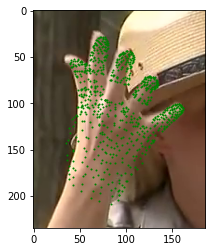

In [56]:
visualize_in_processed_image('../storage/data/'+image['name'], image['width'], image['height'], annotation_list[0])

In [57]:
# Process vertex set and image (Pipeline for a single image)
shifted_vertices, mat, bbx = shift_vertices(annotation_list[0]['vertices'])
orig_image = Image.open('../storage/data/'+image['name'])
cropped_image = crop_image(orig_image, image['width'], image['height'], bbx)

cropped_image, flipped_vertices, flip_mat = flip_hand(shifted_vertices, mat, cropped_image, 1)

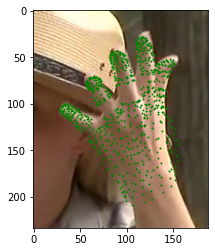

In [58]:
plot_and_show(cropped_image, flipped_vertices)

In [59]:
width = cropped_image.shape[1]
height = cropped_image.shape[0]
# print(width, height)

large_side = max(width, height)
scale = OUT_IMAGE_SIZE[0] / large_side

# image = image.thumbnail(OUT_IMAGE_SIZE, Image.ANTIALIAS)
scaled_image = Image.fromarray(cropped_image).resize((int(scale * width), int(scale * height)), 2)
# print(width*scale, height*scale)

scale_mat = scaling_mat(scale, scale)
width_padding = int(OUT_IMAGE_SIZE[0] - scale * width)
height_padding = int(OUT_IMAGE_SIZE[0] - scale * height)

pad_mat = translation_mat( width_padding/2, height_padding/2)
padded_image = Image.new("RGB", OUT_IMAGE_SIZE)
padded_image.paste(scaled_image, (width_padding//2, height_padding//2))

scaled_vertices = flipped_vertices @ scale_mat.T
padded_vertices = scaled_vertices @ pad_mat.T

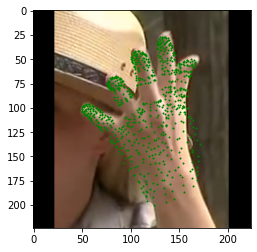

In [60]:
plot_and_show(padded_image, padded_vertices)

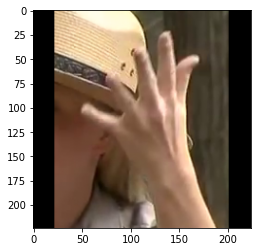

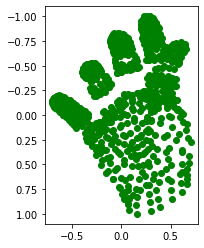

In [61]:
new_bbx = bounding_box(padded_vertices[:, 0:3], 0)
padded_image = np.array(padded_image)
normalized_image = padded_image / 255
# print(normalized_image.max())
plot_and_show(normalized_image)

vertex_scale = new_bbx[1, :] - new_bbx[0, :]
vertex_scale[:] = vertex_scale.max()/2
normalize_mat = (translation_mat(*((- new_bbx[0, :] - new_bbx[1, :])/2)).T @
                    scaling_mat(*(1/(vertex_scale+EPSILON))).T).T
normalized_vertices = padded_vertices @ normalize_mat.T

plot_vertices(normalized_vertices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


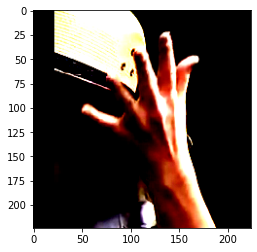

In [62]:
## Dataset Normalization (Images)
intensity_normalized_image = (normalized_image - imagenet_mean)/imagenet_std
plot_and_show(intensity_normalized_image)
## Normalize anns using dataset stats

In [63]:
def process_data(image, image_width, image_height, hand_is_left, annotation, augment):
    """
    Cumulative function for input data processing
    """
    shifted_vertices, mat, bbx = shift_vertices(annotation, augment)
    cropped_image = crop_image(image, image_width, image_height, bbx)

    cropped_image, flipped_vertices, flip_mat = flip_hand(shifted_vertices, mat, cropped_image, hand_is_left)
    
    width = cropped_image.shape[1]
    height = cropped_image.shape[0]

    large_side = max(width, height)
    scale = OUT_IMAGE_SIZE[0] / large_side

    scaled_image = Image.fromarray(cropped_image).resize((int(scale * width), int(scale * height)), 2)

    scale_mat = scaling_mat(scale, scale)
    width_padding = int(OUT_IMAGE_SIZE[0] - scale * width)
    height_padding = int(OUT_IMAGE_SIZE[0] - scale * height)

    pad_mat = translation_mat( width_padding/2, height_padding/2)
    padded_image = Image.new("RGB", OUT_IMAGE_SIZE)
    padded_image.paste(scaled_image, (width_padding//2, height_padding//2))

    scaled_vertices = flipped_vertices @ scale_mat.T
    padded_vertices = scaled_vertices @ pad_mat.T
    
    new_bbx = bounding_box(padded_vertices[:, 0:3], 0)
    padded_image = np.array(padded_image)
    normalized_image = padded_image / 255.0
    
    vertex_scale = new_bbx[1, :] - new_bbx[0, :]
    vertex_scale[:] = vertex_scale.max()/2
    normalize_mat = (translation_mat(*((- new_bbx[0, :] - new_bbx[1, :])/2)).T @
                        scaling_mat(*(1/(vertex_scale+EPSILON))).T).T

    #### IMP How to dataset normalize annotations ???
    normalized_vertices = padded_vertices @ normalize_mat.T
    
    intensity_normalized_image = (normalized_image - imagenet_mean) / imagenet_std
    
    
    affine_mat = pad_mat @ scale_mat @ flip_mat @ mat
    return annotation, normalized_image, normalized_vertices[:, :3], affine_mat[:3, :3]

In [64]:
def process_data_wrapper(image_path, image_width, image_height, hand_is_left, annotation_idx, augment):
    """
    Perform input data reading and calling cumulative processing function
    """
    annotations = train_data['annotations'][annotation_idx.numpy()]['vertices']
    image = Image.open(image_path.numpy())
    
    image_height = image_height.numpy()
    image_width = image_width.numpy()
    hand_is_left = hand_is_left.numpy()
    
    annotations_uvd, normalized_image, normalized_annotations, affine_mat = process_data(image, image_width, image_height, hand_is_left, annotations, augment)
    
    return annotations_uvd, normalized_image, normalized_annotations, affine_mat

In [65]:
def get_raw_data_as_tf_dataset(storage_dir, images, annotations):
    image_dct = {}
    image_path = []
    image_width = []
    image_height = []
    hand_is_left = []
    annotation_idx = []
    map_img_to_path(image_dct, images)
    map_img_to_ann(image_dct, annotations)
    for idx, img in enumerate(image_dct.keys()):
        image_dct[img]['path'] = os.path.join(storage_dir, image_dct[img]['path'])
        for ann in image_dct[img]['ann']:
            image_path.append(image_dct[img]['path'])
            image_width.append(image_dct[img]['width'])
            image_height.append(image_dct[img]['height'])
            hand_is_left.append(annotations[ann]['is_left'])
            annotation_idx.append(ann)

        if idx > 2000:
            break
        
    
    ds_raw = tf.data.Dataset.from_tensor_slices((image_path, image_width, image_height, hand_is_left, annotation_idx))

    return ds_raw

In [66]:
def process_ds(image_path, image_width, image_height, hand_is_left, annotation_idx, augment):
    #Load image and annotations from text file later
    
    annotations_uvd, normalized_image, normalized_annotations, affine_mat = tf.py_function(
        func = process_data_wrapper,
        inp = [image_path, image_width, image_height, hand_is_left, annotation_idx, augment],
        Tout = [tf.float32, tf.float32, tf.float32, tf.float32]
    )
    
    annotations_uvd.set_shape([778, 3])
    normalized_image.set_shape([OUT_IMAGE_SIZE[0], OUT_IMAGE_SIZE[1], 3])
    normalized_annotations.set_shape([778, 3])
    affine_mat.set_shape([3, 3])
    
#     return (
#         {"normalized_image" : normalized_image, "affine_mat" : affine_mat},
#         {"normalized_annotations" : normalized_annotations, "annotations_uvd" : annotations_uvd}
#     )
    return normalized_image, normalized_annotations

In [67]:
def process_tf_dataset(ds_raw, augment):
    ds_processed = ds_raw.map(
                        lambda image_path, image_width, image_height, hand_is_left, annotation_id : process_ds(
                                image_path, image_width, image_height, hand_is_left, annotation_id, augment))
    
    return ds_processed

In [68]:
def get_processed_dataset_as_tf_dataset(storage_dir, images, annotations):
    ds_raw = get_raw_data_as_tf_dataset(storage_dir, images, annotations)
    
    n_data = ds_raw.cardinality().numpy()
    train_frac = 1
    n_data_train = int(n_data * train_frac)
    ds_train = ds_raw.take(n_data_train)
    ds_val = ds_raw.skip(n_data_train)
    
    ds_train = process_tf_dataset(ds_train, True)
    ds_train = ds_train.apply(tf.data.experimental.ignore_errors())
    ds_val = process_tf_dataset(ds_val, False)

    return ds_train, ds_val
    

In [69]:
ds_train, ds_val = get_processed_dataset_as_tf_dataset('../storage/data/', train_data['images'], train_data['annotations'])

In [70]:
ds_train = ds_train.shuffle(1000).batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(32)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

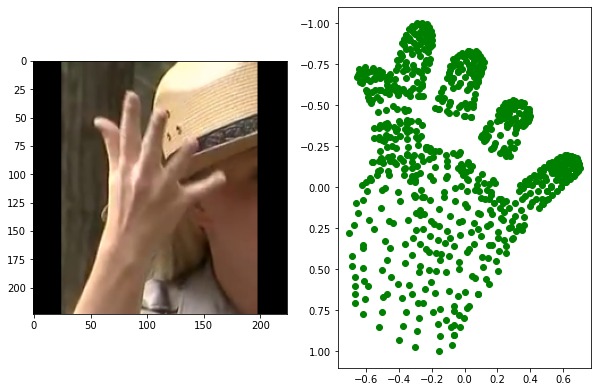

In [71]:
#Check output
fig = plt.figure(figsize=(10,10))
for ds in ds_train:
    plt.subplot(121)
    plt.imshow(ds[0][0].numpy())
    ax = fig.add_subplot(122)
    vertex_set = ds[1][0].numpy()
    ax.plot(vertex_set[:, 0], vertex_set[:, 1], "go")
    ax.set_aspect("equal")
    ax.invert_yaxis()
    break

In [72]:
mano = Mano('../storage/MANO_RIGHT.pkl')

In [73]:
sparse_edge_mat = tf.convert_to_tensor(get_edge_mat(mano.triangles, len(mano.V_temp)), dtype=tf.float32)

In [74]:
sparse_edge_mat.shape

TensorShape([2315, 778])

In [75]:
def get_sparse_edge_mat(edge_mat):
    """
    edge_mat: Num_edges_in_face*778 
    """
    edge_mat = scipy.sparse.csr_matrix(edge_mat)
    edge_mat = edge_mat.tocoo()
    indices = np.column_stack((edge_mat.row, edge_mat.col))
    edge_mat = tf.SparseTensor(indices, edge_mat.data, edge_mat.shape)
    edge_mat = tf.sparse.reorder(edge_mat)
    return edge_mat

In [76]:
tensor_edge_mat = get_sparse_edge_mat(sparse_edge_mat)

In [77]:
def loss_function(y_true, y_pred):
    num_verts = tf.shape(y_true)[1]
    num_edges = tf.shape(tensor_edge_mat)[0]
    y_true = tf.transpose(y_true, perm=[1, 2, 0]) # 778 x 3 x N
    y_true = tf.reshape(y_true, [num_verts, -1])  # 778 x 3N
    y_pred = tf.transpose(y_pred, perm=[1, 2, 0]) # 778 x 3 x N
    y_pred = tf.reshape(y_pred, [num_verts, -1])  # 778 x 3N
    edge_true = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_true) # num_edges x 3N
    edge_pred = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_pred) # num_edges x 3N
    edge_pred = tf.reshape(edge_pred, [num_edges, 3, -1])
    edge_true = tf.reshape(edge_true, [num_edges, 3, -1])
    y_pred = tf.reshape(y_pred, [num_verts, 3, -1])
    y_true = tf.reshape(y_true, [num_verts, 3, -1])

#     tf.print(tf.shape(y_true), tf.shape(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0)), tf.shape(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0)), output_stream=sys.stdout)
#     tf.print(tf.norm(edge_true, ord='euclidean', axis=1) - tf.norm(edge_pred, ord='euclidean', axis=1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.norm(y_true - y_pred, ord=1, axis=1), axis=-1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.reduce_mean(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1)), axis=-1), axis=-1))
#     tf.print(tf.reduce_max(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1))), output_stream=sys.stdout)
#     tf.autograph.trace()
#     tf.autograph.trace()

    return lamb_vert * tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0)) + lamb_edge * tf.reduce_mean(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0))

In [78]:
## Code from SpiralConve paper
def _next_ring(mesh, last_ring, other):
    res = []

    def is_new_vertex(idx):
        return (idx not in last_ring and idx not in other and idx not in res)

    for vh1 in last_ring:
        vh1 = om.VertexHandle(vh1)
        after_last_ring = False
        for vh2 in mesh.vv(vh1):
            if after_last_ring:
                if is_new_vertex(vh2.idx()):
                    res.append(vh2.idx())
            if vh2.idx() in last_ring:
                after_last_ring = True
        for vh2 in mesh.vv(vh1):
            if vh2.idx() in last_ring:
                break
            if is_new_vertex(vh2.idx()):
                res.append(vh2.idx())
    return res


def extract_spirals(mesh, seq_length, dilation=1):
    # output: spirals.size() = [N, seq_length]
    spirals = []
    for vh0 in mesh.vertices():
        reference_one_ring = []
        for vh1 in mesh.vv(vh0):
            reference_one_ring.append(vh1.idx())
        spiral = [vh0.idx()]
        one_ring = list(reference_one_ring)
        last_ring = one_ring
        next_ring = _next_ring(mesh, last_ring, spiral)
        spiral.extend(last_ring)
        while len(spiral) + len(next_ring) < seq_length * dilation:
            if len(next_ring) == 0:
                break
            last_ring = next_ring
            next_ring = _next_ring(mesh, last_ring, spiral)
            spiral.extend(last_ring)
        if len(next_ring) > 0:
            spiral.extend(next_ring)
        else:
            kdt = KDTree(mesh.points(), metric='euclidean')
            spiral = kdt.query(np.expand_dims(mesh.points()[spiral[0]],
                                              axis=0),
                               k=seq_length * dilation,
                               return_distance=False).tolist()
            spiral = [item for subspiral in spiral for item in subspiral]
        spirals.append(spiral[:seq_length * dilation][::dilation])
    return spirals


def preprocess_spiral(face, seq_length, vertices=None, dilation=1):
    assert face.shape[1] == 3
    if vertices is not None:
        mesh = om.TriMesh(np.array(vertices), np.array(face))
    else:
        n_vertices = face.max() + 1
        mesh = om.TriMesh(np.ones([n_vertices, 3]), np.array(face))
    spirals = extract_spirals(mesh, seq_length=seq_length, dilation=dilation)
    return spirals

In [79]:
class SpiralConv(tf.keras.layers.Layer):
    
    def __init__(self, in_channels, out_channels, indices, dim=1):
        super(SpiralConv, self).__init__()
        self.dim = dim
        self.indices = indices
        self.nodes = tf.shape(indices)[0]
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.inp_dense = self.in_channels*tf.shape(indices)[1]
        self.layer = tf.keras.layers.Dense(out_channels)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        x = tf.reshape(tf.gather(inputs, tf.reshape(self.indices, [-1]), axis=1), [batch_size, self.nodes, self.inp_dense])
        return x
    
    def model(self):
        inputs = tf.keras.Input(shape=(self.nodes, self.in_channels))
        x = self.call(inputs)
        outputs = self.layer(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

In [80]:
mesh = Mesh(v=mano.V_temp, f=mano.triangles)
M,A,D,U = generate_transform_matrices(mesh, [2, 2, 2, 2])
print("set of meshes", M)
print("Adjacency matrix", A)
print("Downsampling transforms", D)
print("Upsampling transforms", U)

/Users/debabratamandal/sem8/RnD/code/RnD/dataset/mesh_sampling.py:67: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs_v[3 * i:3 * i + 3] = np.linalg.lstsq(A, nearest_v)[0]
/Users/debabratamandal/sem8/RnD/code/RnD/dataset/mesh_sampling.py:71: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  tmp_coeffs = np.linalg.lstsq(A, target.v[i])[0]


set of meshes [<psbody.mesh.mesh.Mesh object at 0x156e927f0>, <psbody.mesh.mesh.Mesh object at 0x156d2fb00>, <psbody.mesh.mesh.Mesh object at 0x152e0ccf8>, <psbody.mesh.mesh.Mesh object at 0x15290d6d8>, <psbody.mesh.mesh.Mesh object at 0x156e92c88>]
Adjacency matrix [<778x778 sparse matrix of type '<class 'numpy.float64'>'
	with 4630 stored elements in Compressed Sparse Column format>, <389x389 sparse matrix of type '<class 'numpy.float64'>'
	with 2298 stored elements in Compressed Sparse Column format>, <195x195 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 stored elements in Compressed Sparse Column format>, <98x98 sparse matrix of type '<class 'numpy.float64'>'
	with 558 stored elements in Compressed Sparse Column format>, <49x49 sparse matrix of type '<class 'numpy.float64'>'
	with 266 stored elements in Compressed Sparse Column format>]
Downsampling transforms [<389x778 sparse matrix of type '<class 'numpy.float64'>'
	with 389 stored elements in Compressed Sparse Colu

In [89]:
class Upsampling(tf.keras.layers.Layer):
    ## Sparse Mult code from coma
    def __init__(self, upsampling_matrix):
        super(Upsampling, self).__init__()
        self.mat = upsampling_matrix
        type(self.mat)
        self.mat = self.mat.tocoo()
        indices = np.column_stack((self.mat.row, self.mat.col))
        self.mat = tf.sparse.SparseTensor(indices, self.mat.data, self.mat.shape)
        self.mat = tf.sparse.reorder(self.mat)
        self.Mp = self.mat.shape[0]
    
    def call(self, inputs):
        N = tf.shape(inputs)[0]
        M = tf.shape(inputs)[1]
        Fin = tf.shape(inputs)[2]
        N, M, Fin = int(N), int(M), int(Fin)

        x = tf.transpose(inputs, perm=[1, 2, 0])  # M x Fin x N
        x = tf.reshape(x, [M, -1])  # M x Fin*N
        ##Speed up using sparse matrix multiplication
        x = tf.sparse.sparse_dense_matmul(self.mat, x) # Mp x Fin*N
        x = tf.reshape(x, [self.Mp, Fin, -1])  # Mp x Fin x N
        x = tf.transpose(x, perm=[2,0,1]) # N x Mp x Fin
        return x

In [94]:
upml1 = Upsampling(scipy.sparse.csc_matrix.astype(U[0], dtype=np.float32))
upml2 = Upsampling(scipy.sparse.csc_matrix.astype(U[1], dtype=np.float32))

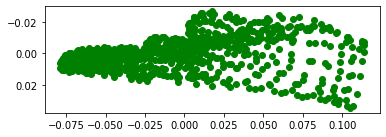

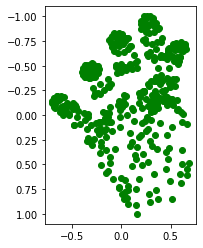

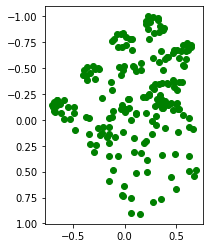

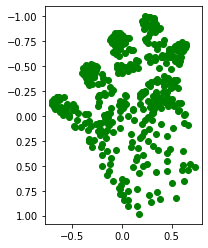

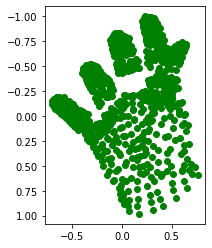

In [104]:
plot_vertices(mano.V_temp)
down_sampled = D[0] @ normalized_vertices[:,:3]
plot_vertices(down_sampled)
down_sampled = D[1] @ down_sampled
plot_vertices(down_sampled)

up_sampled = upml2.call(tf.convert_to_tensor([down_sampled], dtype=tf.float32))
plot_vertices(up_sampled[0])
up_sampled = upml1.call(tf.convert_to_tensor(up_sampled, dtype=tf.float32))
plot_vertices(up_sampled[0])

In [52]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000)

In [53]:
inputs = tf.keras.Input(shape=(*OUT_IMAGE_SIZE, 3), name="normalized_image")

In [54]:
x = resnet50(inputs)

In [55]:
x = tf.keras.layers.Dense(778*3, activation=tf.keras.activations.relu, name="FC2")(x)

In [56]:
x = tf.keras.layers.Reshape((778, 3), name="reshape_to_mesh")(x)

In [57]:
outputs = x

In [58]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [59]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_image (InputLayer [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
FC2 (Dense)                  (None, 2334)              2336334   
_________________________________________________________________
reshape_to_mesh (Reshape)    (None, 778, 3)            0         
Total params: 27,973,046
Trainable params: 27,919,926
Non-trainable params: 53,120
_________________________________________________________________


In [60]:
## Implement scheduler
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_function,
)

In [ ]:
model.fit(ds_train, batch_size=1, epochs=10000, validation_data=ds_val,steps_per_epoch=1)

Epoch 1/10000
1/1 [==============================] - 9s 9s/step - loss: 8.1354
Epoch 2/10000
1/1 [==============================] - 1s 911ms/step - loss: 8.0391
Epoch 3/10000
1/1 [==============================] - 1s 913ms/step - loss: 8.0964
Epoch 4/10000
1/1 [==============================] - 1s 913ms/step - loss: 8.0385
Epoch 5/10000
1/1 [==============================] - 1s 901ms/step - loss: 8.0383
Epoch 6/10000
1/1 [==============================] - 1s 916ms/step - loss: 8.0858
Epoch 7/10000
1/1 [==============================] - 1s 944ms/step - loss: 8.0280
Epoch 8/10000
1/1 [==============================] - 1s 914ms/step - loss: 8.1044
Epoch 9/10000
1/1 [==============================] - 1s 903ms/step - loss: 8.0754
Epoch 10/10000
1/1 [==============================] - 1s 903ms/step - loss: 8.0367
Epoch 11/10000
1/1 [==============================] - 1s 899ms/step - loss: 8.0843
Epoch 12/10000
1/1 [==============================] - 1s 909ms/step - loss: 8.1224
Epoch 13/10000
1

In [ ]:
pred = model.predict(np.array([rotated_and_scaled_image]), batch_size=1)

In [ ]:
viz_3d(pred[0], mano.triangles)

In [ ]:
plot_vertices(pred[0])

In [ ]:
model.save_weights('./my_checkpoint')